# NHL Defensemen Clustering

This file is used to cluster the NHL Defensemen into tiers.



## Import Libraries

In [19]:
import pandas as pd
import numpy as np

## Defensemen Clustering

In [20]:
# Load Defensemen
nhl_defensemen = pd.read_csv('../dataset/preprocess/nhl_defensemen.csv')

In [21]:
nhl_defensemen.shape

(806, 71)

### Processing Stats Attributes (numeric)

- Select numeric columns

- Standardize them

In [22]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
stats_cols = [
    "gp_regular_total", "g_regular_sum", "a_regular_sum", "p_regular_sum", "plus_minus_regular_sum", "pim_regular_sum",
    "ppg_regular_sum", "ppp_regular_sum", "shg_regular_sum", "shp_regular_sum",
    "gwg_regular_sum", "otg_regular_sum", "sog_regular_sum",
    "shooting_pct_regular_mean", "fo_pct_regular_mean", "toi_per_game_regular_mean",
    "g_regular_per_game", "a_regular_per_game", "p_regular_per_game",
    "sog_regular_per_game", "pim_regular_per_game",
    "gp_playoffs_sum", "g_playoffs_sum", "a_playoffs_sum", "p_playoffs_sum", "plus_minus_playoffs_sum", "pim_playoffs_sum",
    "ppg_playoffs_sum", "ppp_playoffs_sum", "shg_playoffs_sum", "shp_playoffs_sum",
    "gwg_playoffs_sum", "otg_playoffs_sum", "sog_playoffs_sum",
    "shooting_pct_playoffs_mean", "fo_pct_playoffs_mean", "toi_per_game_playoffs_mean",
    "g_playoffs_per_game", "a_playoffs_per_game", "p_playoffs_per_game",
    "sog_playoffs_per_game", "pim_playoffs_per_game"
]
X_stats = nhl_defensemen[stats_cols].values

# Find the indices of the toi_per_game_regular_mean
toi_per_game_regular_mean_idx = stats_cols.index("toi_per_game_regular_mean")
# Fill the NaNs in toi_per_game_regular_mean with it's mean
X_stats[:, toi_per_game_regular_mean_idx] = np.nan_to_num(X_stats[:, toi_per_game_regular_mean_idx], nan=np.nanmean(X_stats[:, toi_per_game_regular_mean_idx]))

# Impute NaNs with 0
X_stats = np.nan_to_num(X_stats, nan=0)

# Scale the stats
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(X_stats)

# Add Weight to the stats
# Find the index of p_regular_per_game
p_regular_per_game_idx = stats_cols.index("p_regular_per_game")
# Find the index of gp_regular_total
gp_regular_total_idx = stats_cols.index("gp_regular_total")

# Add weight to toi_per_game_regular_mean, p_regular_per_game, and gp_regular_total
X_stats_scaled[:, toi_per_game_regular_mean_idx] *= 1.3
X_stats_scaled[:, p_regular_per_game_idx] *= 1.3
# X_stats_scaled[:, gp_regular_total_idx] *=

In [23]:
from sklearn.impute import SimpleImputer

# Handle Body Attributes (numeric)
body_cols = ["height_cm", "weight_kg"]

X_body = nhl_defensemen[body_cols].values

# Impute NaN using Imputer
imputer = SimpleImputer(strategy='mean')
X_body = imputer.fit_transform(X_body)

# Scale the body attributes
scaler = StandardScaler()
X_body_scaled = scaler.fit_transform(X_body)

## Categorical Encoding

- `player_type` -> One-hot encoding

- `draft`

    - Convert into structured features: round, overall, year

- `highlights`

    - Treat as multi-label categorical

    - Convert to binary indicators (bag-of-words style).

In [24]:
import ast

# Step 1: Ensure player_type column is always a list
def parse_types(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)  # safely evaluate string representation of list
        except (ValueError, SyntaxError):
            return [x.strip()] if x.strip() else []
    return []

nhl_defensemen['player_type'] = nhl_defensemen['player_type'].apply(parse_types)

# Step 2: Get all unique player types
all_types = sorted(set(pt for types in nhl_defensemen['player_type'] for pt in types))

# Step 3: One-hot encode player types
for pt in all_types:
    col_name = f"player_type_{pt.replace(' ', '_').lower()}"
    nhl_defensemen[col_name] = nhl_defensemen['player_type'].apply(lambda x: int(pt in x))

# Step 4: Select the one-hot encoded columns
X_player_type = nhl_defensemen[[col for col in nhl_defensemen.columns if col.startswith("player_type_")]]

# Impute NaNs with 0
X_player_type = X_player_type.fillna(0)

In [25]:
# Handle Draft
nhl_defensemen['draft_round'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[0]) if pd.notnull(x) else None)
nhl_defensemen['draft_overall'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[1]) if pd.notnull(x) else None)
nhl_defensemen['draft_year'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[2]) if pd.notnull(x) else None)

# Extract Draft Features into X_draft
draft_cols = ['draft_round', 'draft_overall']
X_draft = nhl_defensemen[draft_cols].values

# Impute Undrafted with max + 1
X_draft[:, 0] = np.nan_to_num(
    X_draft[:, 0], nan=np.nanmax(X_draft[:, 0]) + 1
)
X_draft[:, 1] = np.nan_to_num(
    X_draft[:, 1], nan=np.nanmax(X_draft[:, 1]) + 1
)


# Standardize draft features
scaler = StandardScaler()
X_draft_scaled = scaler.fit_transform(X_draft)

In [26]:
nhl_defensemen.shape

(806, 95)

### Handle Highlights

1. Extract NHL-related Highlights

2. Normalizes the Name of the Awards

3. Parse the `highligts` column for each player to count the number of time they won each award.

4. Impute NaNs with 0

5. Standardize the highlights

6. Add weight to the certain awards:


In [27]:
import ast
import re

# Convert stringified list to an actual list
nhl_defensemen['highlights'] = nhl_defensemen['highlights'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Flatten all the highlights into one list
all_highlights = [h for highlights in nhl_defensemen['highlights'] for h in highlights]

# Use regex to extract the pattern of each highlight
pattern = re.compile(r"^\d+-time\s+")

# Filter out all the NHL-related highlights
filtered_highlights = [
    h for h in all_highlights
    if "NHL" in h or "Hockey Hall of Fame" in h
]

# Remove the "X-time " and extra white space
normalized_highlights = [pattern.sub("", h).strip() for h in filtered_highlights]

# Keep *only* "Hockey Hall of Fame" (drop Finnish/other versions)
normalized_highlights = [
    h for h in normalized_highlights
    if "NHL" in h or h == "Hockey Hall of Fame"
]

# Get all unique highlights
unique_highlights = sorted(set(normalized_highlights))

# Print out the unique NHL awards for keywords definition
# unique_highlights

In [28]:
# Define NHL-related awards
nhl_awards = {
    # Performance Related Awards
    "all_rookie_team": "NHL All-Rookie Team",
    "norris": "NHL Best Defenseman (Norris Trophy)",
    "first_all_star_team": "NHL First All-Star Team",
    "second_all_star_team": "NHL Second All-Star Team",
    "most_assists": "NHL Most Assists",
    "hart": "NHL Most Valuable Player (Hart Trophy)",
    "calder": "NHL Rookie of the Year (Calder Trophy)",
    "stanley_cup": "NHL Stanley Cup Champion",
    "conn_smythe": "NHL Stanley Cup MVP (Conn Smythe Trophy)",
    "ted_lindsay": "NHL MVP Selected by NHLPA (Ted Lindsay Award)",
    "hhof": "Hockey Hall of Fame",

    # Conducts, Sportsmanship, and Leadership Related Awards
    "lester_patrick_trophy": "NHL Contribution to U.S. Hockey (Lester Patrick Trophy)",
    "lady_byng_trophy": "NHL Gentleman of the Game (Lady Byng Trophy)",
    "king_clancy_trophy": "NHL Leadership-Humanitarian Award (King Clancy Trophy)",
    "mark_messier_leadership": "NHL Mark Messier Leadership Award",
    "masterton_sportsmanship": "NHL Sportsmanship Award (Bill Masterton Trophy)",
}

# Count the number of times that each player wins each award in nhl_awards
def extract_award_counts(awards_list):
    """
        Extract the number of times that each player wins each award in nhl_awards
        :param awards_list:
        :return: award_counts: a dictionary with award names as keys and counts as values
    """
    # Initialize a dictionary to store award counts
    award_counts = {award: 0 for award in nhl_awards.keys()}

    if not awards_list:
        return award_counts

    # Count the number of times that each player wins each award in nhl_awards
    for award in awards_list:
        award_name = str(award).lower()
        # Cleaned award name
        cleaned_award_name = re.sub(r"^\d+-time\s+", "", award_name).strip()
        for key, phrase in nhl_awards.items():
            if phrase.lower() == cleaned_award_name:
                # Get the counts from "X-time"
                match = re.search(r"(\d+)-time", award_name)
                count = int(match.group(1)) if match else 1
                award_counts[key] += count

    return award_counts

# Apply the function to the `highlights` column
award_features = nhl_defensemen['highlights'].apply(extract_award_counts).apply(pd.Series)

# Merge the award features back into the main dataframe
nhl_defensemen = pd.concat([nhl_defensemen, award_features], axis=1)

# Impute the NaNs with 0
nhl_defensemen[award_features.columns] = nhl_defensemen[award_features.columns].fillna(0)

# Standardize the award features
scaler = StandardScaler()
X_highlights_scaled = scaler.fit_transform(nhl_defensemen[award_features.columns].values)

# Add weight to the award features
# Focus on Performance Related Awards
X_highlights_scaled[:, award_features.columns.get_loc("all_rookie_team")] *= 1.1
X_highlights_scaled[:, award_features.columns.get_loc("norris")] *= 5
X_highlights_scaled[:, award_features.columns.get_loc("first_all_star_team")] *= 5
X_highlights_scaled[:, award_features.columns.get_loc("second_all_star_team")] *= 3
X_highlights_scaled[:, award_features.columns.get_loc("hart")] *= 5
X_highlights_scaled[:, award_features.columns.get_loc("calder")] *= 5
X_highlights_scaled[:, award_features.columns.get_loc("stanley_cup")] *= 1.1
X_highlights_scaled[:, award_features.columns.get_loc("conn_smythe")] *= 5
X_highlights_scaled[:, award_features.columns.get_loc("ted_lindsay")] *= 5
X_highlights_scaled[:, award_features.columns.get_loc("hhof")] *= 5

## Combine All Features

- Combine `X_stats_scaled`, `X_body_scaled`, `X_draft_scaled`, `X_player_type`, and `X_highlights_scaled`

In [29]:
from scipy.sparse import hstack, csr_matrix

# Convert dense arrays to sparse matrices before stacking
X_draft_sparse = csr_matrix(X_draft_scaled)
X_highlights_sparse = csr_matrix(X_highlights_scaled)

# Combine all features
X_combined = hstack([X_stats_scaled, X_body_scaled, X_draft_sparse, X_player_type, X_highlights_sparse])

# Global Scaling the combined features
scaler = StandardScaler(with_mean=False)  # doesn't support sparse input
X_combined_scaled = scaler.fit_transform(X_combined)

In [30]:
X_combined_scaled.shape

(806, 83)

In [31]:
# Check NaN before the dimensionality reduction and clustering
import numpy as np

def check_nans(X, name):
    arr = X.toarray() if hasattr(X, "toarray") else X
    print(f"{name}: NaNs = {np.isnan(arr).sum()}")

check_nans(X_stats_scaled, "X_stats_scaled")
check_nans(X_body_scaled, "X_body_scaled")
check_nans(X_draft_scaled, "X_draft_scaled")
check_nans(X_highlights_scaled, "X_highlights_scaled")
check_nans(X_player_type, "X_player_type")

X_stats_scaled: NaNs = 0
X_body_scaled: NaNs = 0
X_draft_scaled: NaNs = 0
X_highlights_scaled: NaNs = 0
X_player_type: NaNs = player_type_agitator                  0
player_type_defensive_defenseman      0
player_type_enforcer                  0
player_type_glue_guy                  0
player_type_heavy_hitter              0
player_type_heavy_shooter             0
player_type_leader                    0
player_type_mobile_defenseman         0
player_type_net-front_presence        0
player_type_offensive_defenseman      0
player_type_pk_specialist             0
player_type_pp_specialist             0
player_type_physical_defenseman       0
player_type_playmaker                 0
player_type_powerful_skater           0
player_type_puck-moving_defenseman    0
player_type_puckhandler               0
player_type_shot_blocker              0
player_type_speedster                 0
player_type_two-way_defenseman        0
player_type_workhorse                 0
dtype: int64


## Dimensionality Reduction

- Use PCA to reduce the dimensionality of the combined features to 2 for visualization.

- Use t-SNE to reduce the dimensionality of the combined features to 2 for visualization.

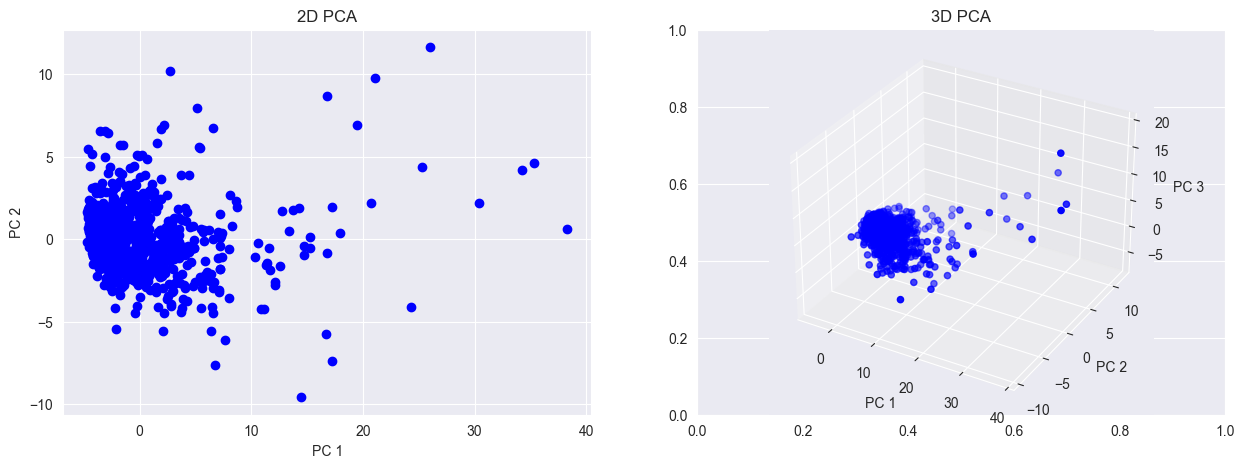

In [32]:
# PCA Dimensionality Reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined_scaled)

# Reduce to 3D for 3D visualization
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_combined_scaled)

# Subplots for 2D Scatter Plot and 3D Scatter Plot
fig, (ax2d, ax3d) = plt.subplots(1, 2, figsize=(15, 5))

# 2D Scatter Plot
ax2d.scatter(X_pca[:, 0], X_pca[:, 1], c='b', marker='o')
ax2d.set_title('2D PCA')
ax2d.set_xlabel('PC 1')
ax2d.set_ylabel('PC 2')

# 3D subplot
ax3d = fig.add_subplot(1, 2, 2, projection='3d')
ax3d.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c='b', marker='o')
ax3d.set_title('3D PCA')
ax3d.set_xlabel('PC 1')
ax3d.set_ylabel('PC 2')
ax3d.set_zlabel('PC 3')

plt.show()


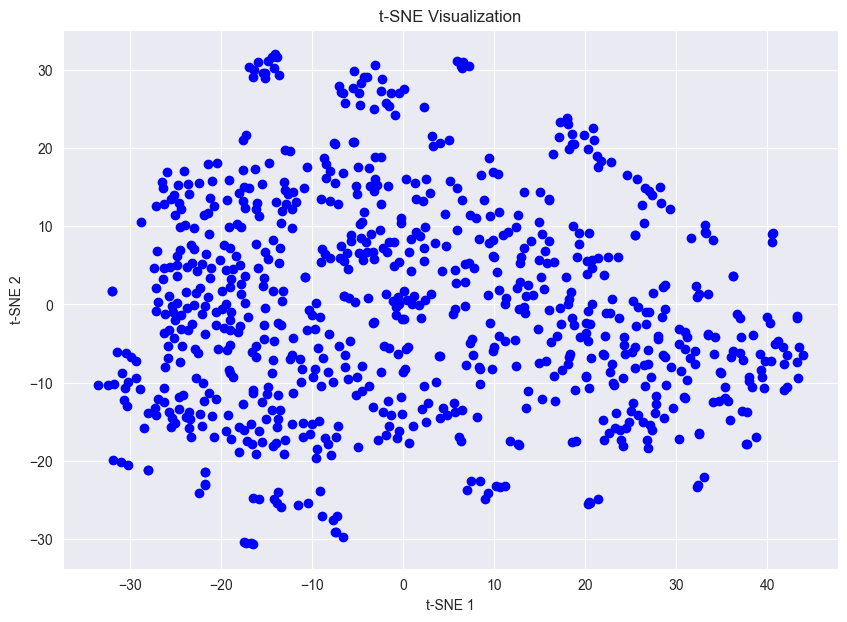

In [33]:
# Visualizing using t-SNE
from sklearn.manifold import TSNE

# t-SNE used dense arrays
X_combined_dense = X_combined_scaled.toarray()

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined_dense)

# 2D t-SNE Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='b', marker='o')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## Clustering

- Use Gaussian Mixture Model to cluster the players into tiers.

    - Since the players are distributed unevenly, KMeans is not a good choice.

    - Also, we want to clustered the players into 4 tiers with different number of players in each tier.

        - GMM gives **soft probabilities** of belonging to each cluster, which is useful if tiers aren't well separated.

In [34]:
# Use Gaussian Mixture Model to cluster the players into tiers
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
labels = gmm.fit_predict(X_combined_dense)

# Add the cluster labels to the dataframe
nhl_defensemen['cluster'] = labels

# Analyze the clusters by toi_per_game_regular_mean, p_regular_per_game
# --- 1. Number of players in each cluster ---
cluster_count = nhl_defensemen['cluster'].value_counts().sort_index()

# --- 2. Continuous features: mean, std, min, max ---
continuous_features = ["toi_per_game_regular_mean", "p_regular_per_game"]

continuous_summary = nhl_defensemen.groupby("cluster")[continuous_features].agg(
    ["mean", "std", "min", "max"]
)

# Flatten multi-index column names
continuous_summary.columns = [
    f"{col}_{stat}" for col, stat in continuous_summary.columns
]

# --- 3. Award features: total count & proportion ---
award_features = [
    "norris", "hhof", "hart", "calder",
    "conn_smythe", "first_all_star_team", "second_all_star_team"
]

award_summary = nhl_defensemen.groupby("cluster")[award_features].agg(
    ["sum", "mean"]   # total wins, and proportion of players in cluster
)

award_summary.columns = [
    f"{col}_{stat}" for col, stat in award_summary.columns
]

# --- 4. Merge everything ---
cluster_summary = pd.concat([cluster_count, continuous_summary, award_summary], axis=1).round(2)

# --- 5. Show results ---
cluster_summary

,count,toi_per_game_regular_mean_mean,toi_per_game_regular_mean_std,toi_per_game_regular_mean_min,toi_per_game_regular_mean_max,p_regular_per_game_mean,p_regular_per_game_std,p_regular_per_game_min,p_regular_per_game_max,norris_sum,...,hart_sum,hart_mean,calder_sum,calder_mean,conn_smythe_sum,conn_smythe_mean,first_all_star_team_sum,first_all_star_team_mean,second_all_star_team_sum,second_all_star_team_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,690,50.71,122.34,7.13,1269.29,0.23,0.11,0.02,0.71,0,...,0,0.00,3,0.00,0,0.00,0,0.00,1,0.00
1,28,485.53,447.22,16.61,1414.73,0.57,0.18,0.34,1.08,15,...,0,0.00,2,0.07,5,0.18,22,0.79,18,0.64
2,1,653.14,NaN,653.14,653.14,0.60,NaN,0.60,0.60,0,...,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00
3,87,493.71,443.40,17.12,1679.80,0.53,0.15,0.27,1.09,25,...,1,0.01,4,0.05,3,0.03,57,0.66,59,0.68


In [41]:
# Show the player in cluster 3, sorted by p_regular_per_season with selected columns
nhl_defensemen[nhl_defensemen['cluster'] == 3].sort_values(
    by="p_regular_per_season", ascending=False
)[[
    "player_name_official", "p_regular_per_season", "toi_per_game_regular_mean",
    "conn_smythe", "hhof", "norris", "calder", "hart",
    "first_all_star_team",    "second_all_star_team"
]]

,player_name_official,p_regular_per_season,toi_per_game_regular_mean,conn_smythe,hhof,norris,calder,hart,first_all_star_team,second_all_star_team
268,Paul Coffey,72.904762,19.270000,0,1,3,0,0,4,4
0,Ray Bourque,71.772727,1679.800000,0,1,5,1,0,13,6
89,Phil Housley,58.666667,19.916667,0,1,0,0,0,0,1
750,Larry Murphy,57.952381,761.708333,0,1,0,0,0,0,3
279,Brian Leetch,57.111111,1473.612963,1,1,2,1,0,2,3
...,...,...,...,...,...,...,...,...,...,...
47,Brad Stuart,20.937500,100.847368,0,0,0,0,0,0,0
562,Derian Hatcher,20.687500,942.090000,0,0,0,0,0,0,1
48,Francois Beauchemin,20.571429,672.627083,0,0,0,0,0,0,1
12,Todd Gill,18.631579,17.716667,0,0,0,0,0,0,0
